# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



**Source**: This dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



## A. Business Understanding

##### _Problem 1: Understanding the Data_

The dataset is collected from a Portuguese bank that used its own contact-center to do directed marketing campaigns - mostly by telephone. The dataset collected is related to **17 campaigns** that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. 

During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a number of attributes was stored and if there was a success (the target variable). For the whole database considered, there were 6499
successes (8% success rate).

##### _Problem 1a: Import Relevant Libraries_

In [1]:
## Basic libs
import pandas as pd
import numpy as np

## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Data Cleaning and Preprocessing   
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 

# Data Modeling and Evaluation
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score
from sklearn.metrics import roc_curve
import time

import warnings
warnings.filterwarnings('ignore')


##### _Problem 2: Load Data and Take a Look_ 

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## B. Explore the Dataset

##### _Problem 3: Understanding the Features_


**bank client data**

| SN      | Feature  | Description     | Type | Values    |
| :------ | :------: | :------ | :------:   | :------   |
| 1       | `age`    | Age of client  | num | NA.       |
| 2       | `job`    | Job type | cat | admin, blue-color, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown|    
|3        |`marital` | marital status (divorced could mean widowed) | cat | divorced, married, single, unknown | 
|4        |`education` | education bg | cat | basic.4y, basic.6y, basic.9y, high.school, illiterate, professional.course, university.degree, unknown| 
| 5       |`default`| has credit in default? | cat | no, yes, unknown |
|6 |`housing`| has housing loan? | cat | no, yes, unknown |
|7 |`loan`| has personal loan? | cat | no, yes, unknown| 


**related with the last contact of the current campaign**

| SN      | Feature     | Description | Type    | Values    |
| :------ | :------:    | :------     | :------:| :------   |
| 8       | `contact`.  | contact communication type | cat |  cellular, telephone | 
| 9       |`month`      | last contact month of year | cat | jan, feb, mar... dec| 
| 10      |`day_of_week`| last contact day of the week | cat | mon, tue, wed, thu, fri |
| 11      |`duration`.  | last contact duration, in seconds | num | na | 

_Important note: SN11 highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model._

**other attributes**
| SN      | Feature     | Description | Type    | Values    |
| :------ | :------:    | :------     | :------:| :------   |
|12| `campaign` | #contacts performed during this campaign for this client (incl last contact)| num | na | 
|13| `pdays` | #days that passed by after client was last contacted from prev compaign (999 means not previously contacted) | num | na|  
|14| `previous` | #contacts performed before this campaign and for this client | num | na 
|15| `poutcome` | outcome of the previous marketing campaign | cat| failure, nonexistent, success |

**social and economic context attributes**
| SN      | Feature     | Description | Type    | Values    |
| :------ | :------:    | :------     | :------:| :------   |
|16| `emp.var.rate` | employment variation rate - quarterly indicator | num | na | 
|17| `cons.price.idx` | consumer price index - monthly indicator | num | na | 
|18| `cons.conf.idx` | consumer confidence index - monthly indicator| num | na | 
|19| `euribor3m` | euribor 3 month rate - daily indicator | num | na | 
|20| `nr.employed` | number of employees - quarterly indicator | num | na | 

**Output variable (desired target)**
| SN      | Feature     | Description | Type    | Values    |
| :------ | :------:    | :------     | :------:| :------   |
|21| `y` | has the client subscribed a term deposit? | bin | yes, no | 




##### _Step 3a. Explore General Characteristics_

In [5]:
# explore general features, check for null, data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Considerations for Data Cleaning** 

- there are no NULL/missing values 
- to make y feature binary (0, 1)
- to hot encode categorical features
- to convert 999 pdays into more meaningful value (e.g. -1)

In [3]:
#Convert y value to binary first, for ease of data exploration 
df['y'] = df['y'].map({'yes': 1, 'no': 0}) 
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


##### _Step 3b. Explore Numerical Characteristics_

In [7]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


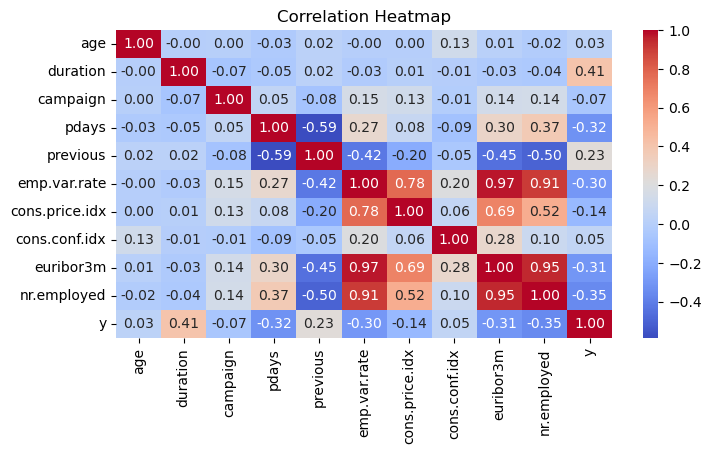

In [8]:
numerical_cols = df.select_dtypes(include=[np.number])
plt.figure(figsize=(8, 4))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

**Observations 3b** 

The most correlated features relative to target value y are: 

| Feature | Description | Correlation  | 
| :------ | :-----------| :-----------:| 
| `duration`| last contact duration in secs | 0.41|  
|`nr.employed`| number of employees | -0.35| 
|`pdays`| #days since last contact | -0.32| 
|`euribor3m`| euribor 3 month rate | -0.31| 
|`emp.var.rate`|employment variation rate | -0.30|

- suggest to ignore `duration`, which is a cheat factor (i.e. longer calls almost always mean that a deposit was subscribed)
- people subscribe more when macro economic situations were poorer (e.g. when employment rate was lower / shrinking i.e. ppl seek safety in deposits, interest rates were lower hence making the deposit cheaper) 
- people subscribe more when they were contacted more recently - older leads go cold.  
- to also note the high correlation between `nr.employed`, `euribor3m`, and `emp.var.rate` > 0.90 i.e. multicollinearity - which could affect modelling with linear models (e.g. logistic regression)

##### _Step 3c. Explore Categorical Features_

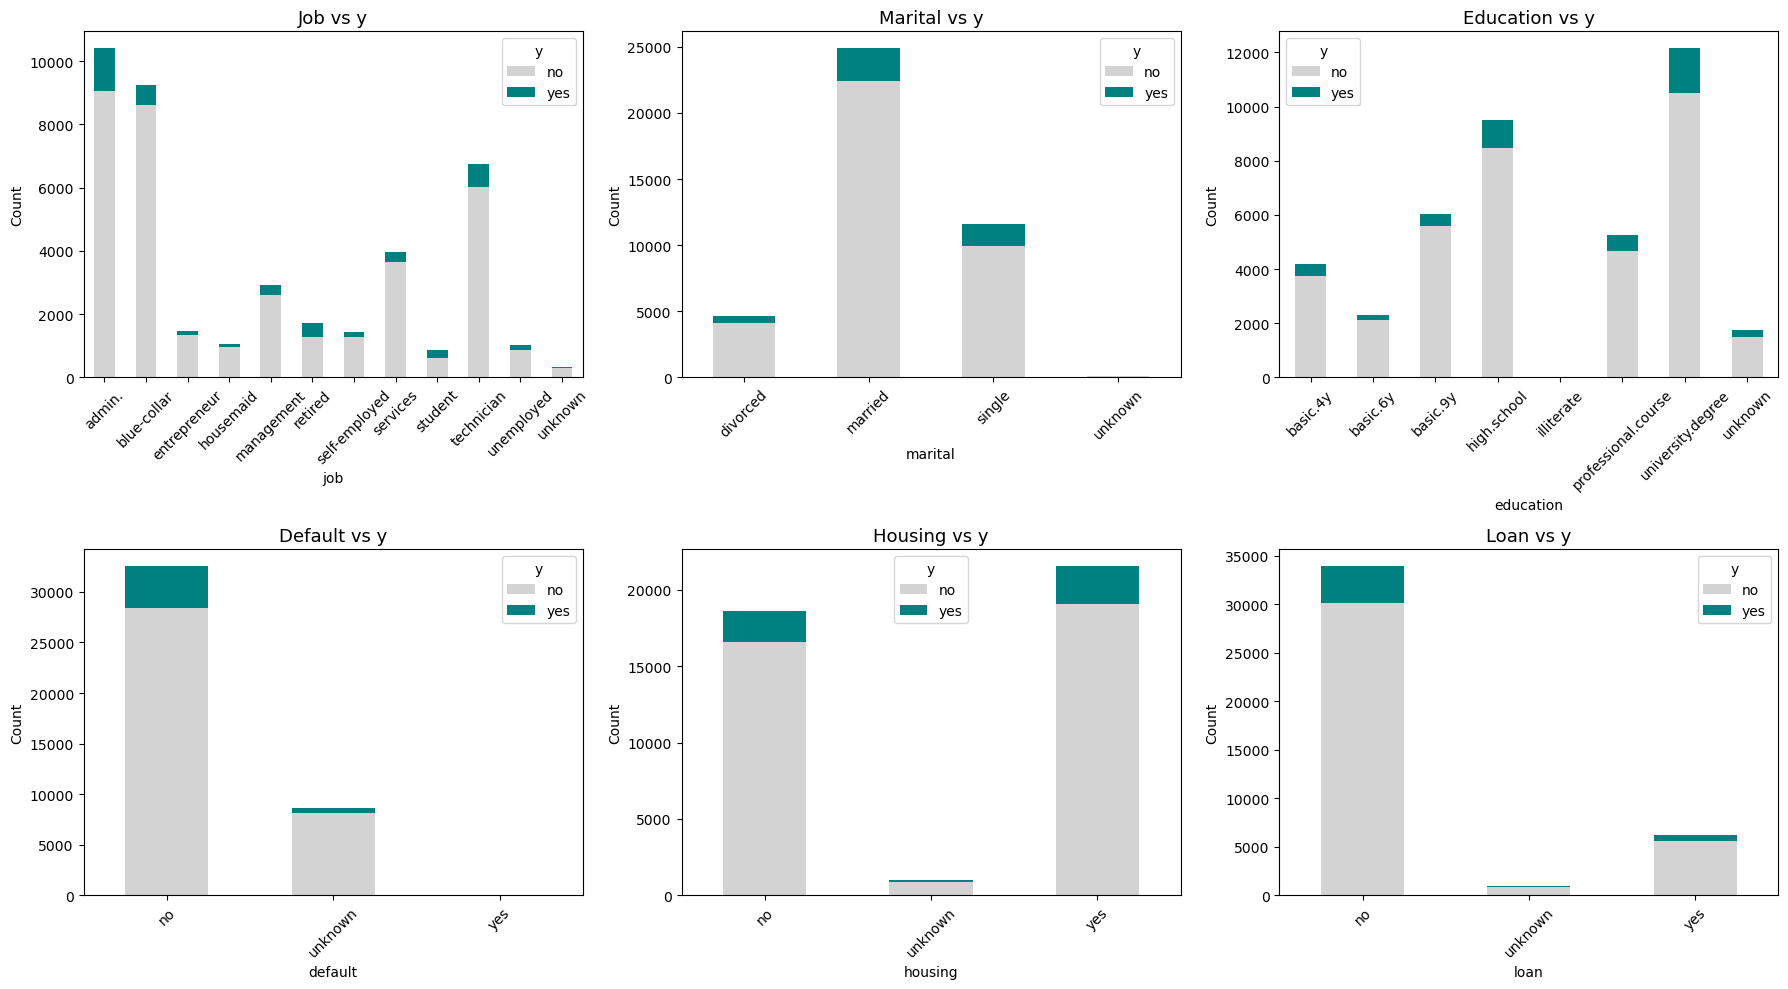

In [9]:
# List categorical columns
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Set up 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop through each categorical feature
for i, col in enumerate(cat_features):
    ax = axes[i]

    # Create a crosstab of category vs outcome
    counts = pd.crosstab(df[col], df['y'])
    
    # Plot stacked bar
    counts.plot(kind='bar', stacked=True, ax=ax, color=['lightgray', 'teal'])
    
    # Titles and labels
    ax.set_title(f'{col.capitalize()} vs y', fontsize=13)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend(title='y', labels=['no', 'yes'])
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Observation 3c**

- Default as a feature may not be meaningful since there are almost no "yes" values (only 3)
- "Unnown" is a very small value within Housing and Loan - may want to remove these for analysis 

##### _Step 3d. Observe target feature spread_

In [10]:
counts = df['y'].value_counts()
percentages = df['y'].value_counts(normalize=True) * 100

y_table = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages.round(2)
})

print(y_table)

   Count  Percentage
y                   
0  36548       88.73
1   4640       11.27


**Observation 3d** 

- the dataset is highly imbalanced with only 11% of the values being y 

##### _Step 3e. Observe unknown features_

In [11]:
for col in ['housing', 'loan', 'marital', 'education']:
    print(df[col].value_counts(normalize=True))

housing
yes        0.523842
no         0.452122
unknown    0.024036
Name: proportion, dtype: float64
loan
no         0.824269
yes        0.151695
unknown    0.024036
Name: proportion, dtype: float64
marital
married     0.605225
single      0.280859
divorced    0.111974
unknown     0.001942
Name: proportion, dtype: float64
education
university.degree      0.295426
high.school            0.231014
basic.9y               0.146766
professional.course    0.127294
basic.4y               0.101389
basic.6y               0.055647
unknown                0.042027
illiterate             0.000437
Name: proportion, dtype: float64


In [11]:
# check how the subscription rate for unknown compares to the overall average
for col in ['marital', 'education']:
    print(pd.crosstab(df[col], df['y'], normalize='index'))

y                0         1
marital                     
divorced  0.896791  0.103209
married   0.898427  0.101573
single    0.859959  0.140041
unknown   0.850000  0.150000
y                           0         1
education                              
basic.4y             0.897510  0.102490
basic.6y             0.917976  0.082024
basic.9y             0.921754  0.078246
high.school          0.891645  0.108355
illiterate           0.777778  0.222222
professional.course  0.886515  0.113485
university.degree    0.862755  0.137245
unknown              0.854997  0.145003


**Observation 3e**

- to consider imputing the unknown category in marital and education since its y spread is comparable to that of the average in the dataset. 

##### _Step 3f. Observe Temporal Features_ 

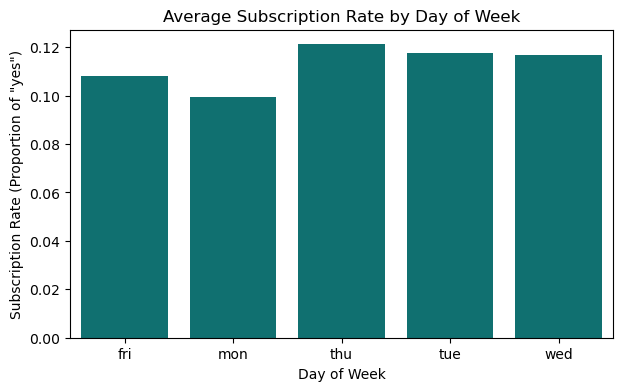

In [12]:
# --- Subscription rate by day of week ---
day_rate = df.groupby('day_of_week')['y'].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(data=day_rate, x='day_of_week', y='y', color='teal')
plt.title('Average Subscription Rate by Day of Week')
plt.ylabel('Subscription Rate (Proportion of "yes")')
plt.xlabel('Day of Week')
plt.show()


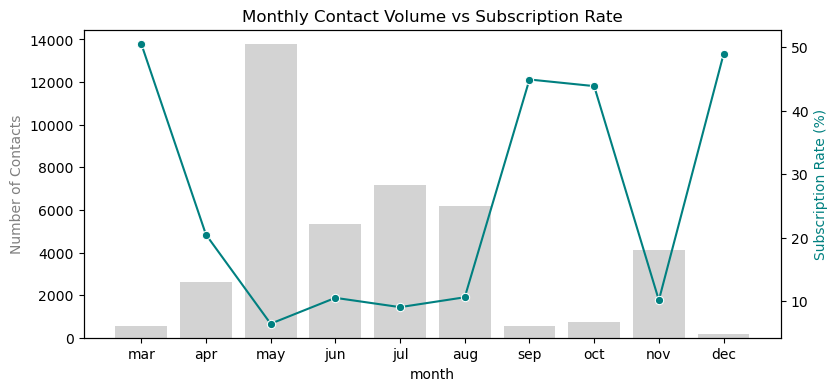

In [13]:
# Subscription rate by month, observed against absolute contact volume 
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
sub_rate = df.groupby('month')['y'].mean().reindex(month_order)

fig, ax1 = plt.subplots(figsize=(9,4))

# Bar for contact volume
contacts_per_month = df['month'].value_counts().reindex(month_order)
sns.barplot(x=contacts_per_month.index, y=contacts_per_month.values, color='lightgrey', ax=ax1)
ax1.set_ylabel('Number of Contacts', color='gray')

# Line for subscription rate
ax2 = ax1.twinx()
sns.lineplot(x=sub_rate.index, y=sub_rate.values*100, color='teal', marker='o', ax=ax2)
ax2.set_ylabel('Subscription Rate (%)', color='teal')

plt.title('Monthly Contact Volume vs Subscription Rate')
plt.show()

**Observation 3f** 

- Somehow subscription rates for March and December are better despite there not being as many calls made during that time. This could be a skew due to simple algebra (when denominator is smaller, proportion is larger for small absolute number of success rates), or there could be some correlation to it being the end of the year (people are reviewing their finances) or nearing the end of a financial year (people are planning expenditure for the next FY)
- subscription rate in summer is the weakest, likely because people are on holiday and spending. 
- No clear correlation with day of week. 

##### _Problem 4: Understanding the Task_

**Business Objective**
The bank conducts phone campaigns to sell term deposits. Each outbound call costs time and money, and repeated calls risk customer fatigue. We want a model that predicts likelihood of subscription (y: 1/0) before the call so we can:
Prioritize high-propensity customers (improve conversion/agent productivity) and De-prioritize low-propensity segments (reduce cost/annoyance). 

**Success metrics**

Given the dataset imbalance, to use AUROC and F1 to better assess model effectiveness. 

## C. Preparing the Data

##### _Problem 5: Engineering Features and Split Data_

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

##### _Step 5a. Cleaning up the data_

In [4]:
# drop duration and default due to leakage and low variance
# drop day_of_week since no clear difference in success rate 
# drop contact method as this could be affected by the generation we are in
df = df.drop(columns=['duration', 'Default', 'day_of_week', 'contact'], errors='ignore')
df.head()

,age,job,marital,education,default,housing,loan,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,may,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [5]:
# impute for marital and education as these are likely missing values 
# leave housing and loan as is as these could have meaning 
for col in ['marital', 'education']:
    mode_val = df.loc[df[col] != 'unknown', col].mode()[0]
    df[col] = df[col].replace('unknown', mode_val)

In [6]:
# fix pdays for skew (999 > -1) and create recency features
df['pdays'] = df['pdays'].replace(999, -1)
# creates new feature indicating if previously contacted (0/1)
df['previous_contacted'] = (df['pdays'] != -1).astype(int)
# creates new feature indicating days since last contact (0 if never contacted)
df['days_since_last_contact'] = df['pdays'].apply(lambda x: 0 if x == -1 else x)
# drop original pdays column
df = df.drop(columns=['pdays'])


##### _Step 5b. Engineering New Meaningful Features_

In [7]:
# Create basic campaign/contact history features for better predictability
df['contacts_all_time'] = df['previous'].fillna(0) + df['campaign'].fillna(0)
# Create a proxy for call intensity, assuming even distribution of calls over days since last contact
df['contact_intensity'] = df['campaign'] / (df['days_since_last_contact'] + 1)
# drop original previous and campaign columns
df = df.drop(columns=['previous', 'campaign'])

df

,age,job,marital,education,default,housing,loan,month,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,previous_contacted,days_since_last_contact,contacts_all_time,contact_intensity
0,56,housemaid,married,basic.4y,no,no,no,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
1,57,services,married,high.school,unknown,no,no,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
2,37,services,married,high.school,no,yes,no,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
3,40,admin.,married,basic.6y,no,no,no,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
4,56,services,married,high.school,no,no,yes,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,nov,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,1,1.0
41184,46,blue-collar,married,professional.course,no,no,no,nov,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,1,1.0
41185,56,retired,married,university.degree,no,yes,no,nov,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,2,2.0
41186,44,technician,married,professional.course,no,no,no,nov,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,1,1.0


In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      41188 non-null  int64  
 1   job                      41188 non-null  object 
 2   marital                  41188 non-null  object 
 3   education                41188 non-null  object 
 4   default                  41188 non-null  object 
 5   housing                  41188 non-null  object 
 6   loan                     41188 non-null  object 
 7   month                    41188 non-null  object 
 8   poutcome                 41188 non-null  object 
 9   emp.var.rate             41188 non-null  float64
 10  cons.price.idx           41188 non-null  float64
 11  cons.conf.idx            41188 non-null  float64
 12  euribor3m                41188 non-null  float64
 13  nr.employed              41188 non-null  float64
 14  y                     

#### _Problem 6: Split the Dataset Before Transforming_

In [8]:
# This avoids StandardScaler data leakage by splitting before transforming
# Preserve the distribution of y in train and test sets using stratify due to class imbalance
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Build pipeline for pre-processing

numeric_tf = Pipeline([
    ('scale', StandardScaler()), #important for logistic regression and SVM
])

categorical_tf = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) #one hot encode categorical features
])

preprocess = ColumnTransformer([
    ('num', numeric_tf, num_cols),
    ('cat', categorical_tf, cat_cols)
])

## D. Data Modeling

##### _Problem 7: A Baseline Model_

##### _Step 7a: Initialise an empty results DataFrame_ 

In [10]:
# Initialize an empty results DataFrame
results_df = pd.DataFrame(columns=['Model', 'Train Time', 'Training Accuracy', 'Test Accuracy', 'ROC_AUC', 'F1_Score'])

##### _Step 7b: A Baseline Zero Rule Model_ 

This guesses based on the highest frequency class in the training data. 

In [11]:
# --- Select features and target ---
X_train_base = preprocess.fit_transform(X_train)
# Avoid training data leakage by only transforming test data
X_test_base  = preprocess.transform(X_test) 

#Instantiate the model 
model_name_base = 'Zero Rule Baseline'
dummy_clf = DummyClassifier(strategy="most_frequent")

# Train the model and record training time 
start_time_base = time.time()
dummy_clf.fit(X_train_base, y_train)
end_time_base = time.time()
training_time_base = end_time_base - start_time_base

# Predict on training data 
y_train_pred_base = dummy_clf.predict(X_train_base)
# Predict on test data
y_test_pred_base = dummy_clf.predict(X_test_base)
y_test_prob_base = dummy_clf.predict_proba(X_test_base)[:, 1]

# Compute metrics
train_acc_base = accuracy_score(y_train, y_train_pred_base)
test_acc_base = accuracy_score(y_test, y_test_pred_base)
roc_base = roc_auc_score(y_test, y_test_prob_base)
f1_base  = f1_score(y_test, y_test_pred_base)

# Append results
results_df.loc[len(results_df)] = [model_name_base, training_time_base, train_acc_base, test_acc_base, roc_base, f1_base]

# Display
results_df

,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.001594,0.887344,0.887351,0.5,0.0


**Observation 7** 

- Baseline model has high accuracy due to dataset imbalance, but poor ROC/AUC and F1 scores. 

##### _Problem 8/9: A Simple Model + Score the Model_

Based on Observations in Step 3b, use `nr.employed` and `previous_contacted` and `days_since_last_contact` to build a baseline logsitic regression model. 

In [12]:
# --- Select features and target ---
X_train_lr3 = X_train[['nr.employed', 'previous_contacted', 'days_since_last_contact']]
X_test_lr3 = X_test[['nr.employed', 'previous_contacted', 'days_since_last_contact']]

#Instantiate the model 
model_name_lr3 = 'Logistic Regression (3 features)'
lr3 = LogisticRegression(max_iter=1000)

# Train the model and record training time 
start_time_lr3 = time.time()              
lr3.fit(X_train_lr3, y_train)
end_time_lr3 = time.time()                 
training_time_lr3 = end_time_lr3 - start_time_lr3 

# Predict on training data 
y_train_pred_lr3 = lr3.predict(X_train_lr3)
# Predict on test data
y_test_pred_lr3 = lr3.predict(X_test_lr3)
y_test_prob_lr3 = lr3.predict_proba(X_test_lr3)[:, 1]
 
# Compute metrics
train_acc_lr3 = accuracy_score(y_train, y_train_pred_lr3)
test_acc_lr3 = accuracy_score(y_test, y_test_pred_lr3)
roc_lr3 = roc_auc_score(y_test, y_test_prob_lr3)
f1_lr3  = f1_score(y_test, y_test_pred_lr3)

# Append results
results_df.loc[len(results_df)] = [model_name_lr3, training_time_lr3, train_acc_lr3, test_acc_lr3, roc_lr3, f1_lr3]

# Display
results_df


,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.001594,0.887344,0.887351,0.500000,0.000000
1,Logistic Regression (3 features),28.274847,0.899090,0.899854,0.770311,0.283232


**Observation 8/9** 

- model already shows improvement from baseline 
- f1 score is very low even though accuracy is high - this could be due to imbalance of y feature 
- due to high imbalance, even if model randomly guesses 'no', it would get >80% accuracy 
- to consider using SMOTE to sample more of the y data 

##### _Problem 10: Model Comparisons_

Compare the baseline and simple logistic regression models we have built, with other models such as KNN, Decision Tree, and SVM. 

##### _Step 10a. Logistic Regression (all features)_

In [13]:
# Select features 
X_train_processed = preprocess.fit_transform(X_train)
X_test_processed  = preprocess.transform(X_test) 

#Instantiate the model 
model_name_lrall = 'Logistic Regression (all features)'
lrall = LogisticRegression(max_iter=1000)

# Train the model and record training time 
start_time_lrall = time.time()
lrall.fit(X_train_base, y_train)
end_time_lrall = time.time()
training_time_lrall = end_time_lrall - start_time_lrall

# Predict on training data 
y_train_pred_lrall = lrall.predict(X_train_processed)
# Predict on test data
y_test_pred_lrall = lrall.predict(X_test_processed)
y_test_prob_lrall = lrall.predict_proba(X_test_processed)[:, 1]

# Compute metrics
train_acc_lrall = accuracy_score(y_train, y_train_pred_lrall)
test_acc_lrall = accuracy_score(y_test, y_test_pred_lrall)
roc_lrall = roc_auc_score(y_test, y_test_prob_lrall)
f1_lrall  = f1_score(y_test, y_test_pred_lrall)

# Append results
results_df.loc[len(results_df)] = [model_name_lrall, training_time_lrall, train_acc_lrall, test_acc_lrall, roc_lrall, f1_lrall]

# Display
results_df

,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.001594,0.887344,0.887351,0.500000,0.000000
1,Logistic Regression (3 features),28.274847,0.899090,0.899854,0.770311,0.283232
2,Logistic Regression (all features),26.468203,0.898816,0.900583,0.795439,0.323699


##### _Step 10b. Decision Tree_

In [14]:
#Instantiate the model 
model_name_dt = 'Decision Tree (default)'
dt = DecisionTreeClassifier(random_state=42)

# Train the model and record training time 
start_time_dt = time.time()
dt.fit(X_train_processed, y_train)
end_time_dt = time.time()
training_time_dt = end_time_dt - start_time_dt

# Predict on training data 
y_train_pred_dt = dt.predict(X_train_processed)
# Predict on test data
y_test_pred_dt = dt.predict(X_test_processed)
y_test_prob_dt = dt.predict_proba(X_test_processed)[:, 1]

# Compute metrics
train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
test_acc_dt = accuracy_score(y_test, y_test_pred_dt)
roc_dt = roc_auc_score(y_test, y_test_prob_dt)
f1_dt  = f1_score(y_test, y_test_pred_dt)

# Append results
results_df.loc[len(results_df)] = [model_name_dt, training_time_dt, train_acc_dt, test_acc_dt, roc_dt, f1_dt]

# Display
results_df

,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.001594,0.887344,0.887351,0.500000,0.000000
1,Logistic Regression (3 features),28.274847,0.899090,0.899854,0.770311,0.283232
2,Logistic Regression (all features),26.468203,0.898816,0.900583,0.795439,0.323699
3,Decision Tree (default),4.444470,0.994082,0.842559,0.631537,0.332476


##### _Step 10c/Problem 11. Decision Tree (tuned)_

In [15]:
#Use GridSearchCV to tune hyperparameters for Decision Tree
model_name_dt_tuned = 'Decision Tree (tuned)'

params = {
    'min_samples_split': [10, 50],
    'min_samples_leaf': [5, 20]
}

#Instantiate the model 
dt_tuned = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=params,
    scoring='f1',       
    cv=5,
    n_jobs=-1
)

# Train the model and record training time 
start_time_dt_tuned = time.time()
dt_tuned.fit(X_train_processed, y_train)
end_time_dt_tuned = time.time()
training_time_dt_tuned = end_time_dt_tuned - start_time_dt_tuned

# Predict on training data 
y_train_pred_dt_tuned = dt_tuned.predict(X_train_processed)
# Predict on test data
y_test_pred_dt_tuned = dt_tuned.predict(X_test_processed)
y_test_prob_dt_tuned = dt_tuned.predict_proba(X_test_processed)[:, 1]       

# Compute metrics
train_acc_dt_tuned = accuracy_score(y_train, y_train_pred_dt_tuned)
test_acc_dt_tuned = accuracy_score(y_test, y_test_pred_dt_tuned)
roc_dt_tuned = roc_auc_score(y_test, y_test_prob_dt_tuned)
f1_dt_tuned  = f1_score(y_test, y_test_pred_dt_tuned)       

# Append results
results_df.loc[len(results_df)] = [model_name_dt_tuned, training_time_dt_tuned, train_acc_dt_tuned, test_acc_dt_tuned, roc_dt_tuned, f1_dt_tuned]

# Display
results_df  

,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.001594,0.887344,0.887351,0.500000,0.000000
1,Logistic Regression (3 features),28.274847,0.899090,0.899854,0.770311,0.283232
2,Logistic Regression (all features),26.468203,0.898816,0.900583,0.795439,0.323699
3,Decision Tree (default),4.444470,0.994082,0.842559,0.631537,0.332476
4,Decision Tree (tuned),143.572077,0.909712,0.893421,0.766488,0.384292


In [27]:
print("Best parameters:", dt_tuned.best_params_)
print("Best F1 score:", dt_tuned.best_score_)

Best parameters: {'min_samples_leaf': 5, 'min_samples_split': 50}
Best F1 score: 0.37174431594137797


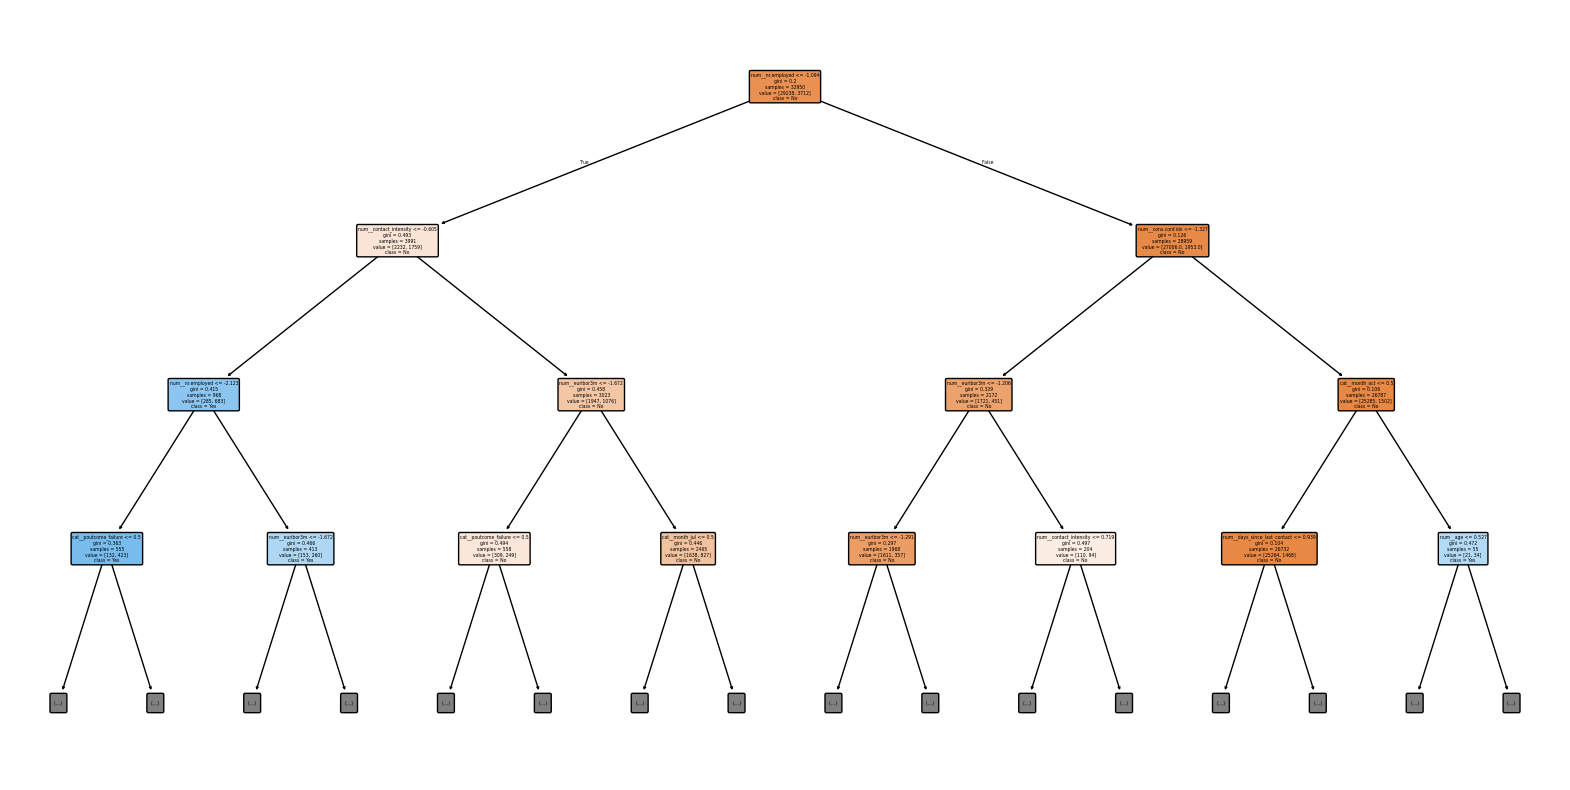

In [28]:
plt.figure(figsize=(20,10))
tree.plot_tree(
    dt_tuned.best_estimator_,                               
    feature_names=preprocess.get_feature_names_out(),    # feature names
    class_names=['No', 'Yes'],        # target class labels
    filled=True,                      # color nodes by class
    rounded=True,                     # rounded node boxes
    max_depth=3                       # show only top levels 
)
plt.show()

**Observation 10c** 

- GridSearchCV improved ROC_AUC and F1_Score significantly even though accuracy reduced
- best parameters were when min samples per leaf was 5 and at least 50 samples before a split is allowed 
- the most deterministic features are `nr_employed`, `contact_intensity`, `euribor3m`, `poutcome_failure`, `days_since_last_contact`, `cons_confi_index`

##### _Step 10d. K Nearest Neighbour_ 

In [16]:
# Instantiate the model 
model_name_knn = 'KNN (default)'
knn = KNeighborsClassifier()

# Train the model and record training time
start_time_knn = time.time()
knn.fit(X_train_processed, y_train)
end_time_knn = time.time()
training_time_knn = end_time_knn - start_time_knn   

# Predict on training data
y_train_pred_knn = knn.predict(X_train_processed)
# Predict on test data  
y_test_pred_knn = knn.predict(X_test_processed)
y_test_prob_knn = knn.predict_proba(X_test_processed)[:, 1]

# Compute metrics
train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)
roc_knn = roc_auc_score(y_test, y_test_prob_knn)
f1_knn  = f1_score(y_test, y_test_pred_knn) 

# Append results
results_df.loc[len(results_df)] = [model_name_knn, training_time_knn, train_acc_knn, test_acc_knn, roc_knn, f1_knn]     
# Display
results_df

,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.001594,0.887344,0.887351,0.500000,0.000000
1,Logistic Regression (3 features),28.274847,0.899090,0.899854,0.770311,0.283232
2,Logistic Regression (all features),26.468203,0.898816,0.900583,0.795439,0.323699
3,Decision Tree (default),4.444470,0.994082,0.842559,0.631537,0.332476
4,Decision Tree (tuned),143.572077,0.909712,0.893421,0.766488,0.384292
5,KNN (default),0.123877,0.912929,0.894270,0.735982,0.366545


##### _Step 10e/Problem 11. KNN (tuned)_

In [17]:
#Use GridSearchCV to tune hyperparameters for KNN
model_name_knn_tuned = 'KNN (tuned)'

params = {
    'n_neighbors': [5, 11],   
    'weights': ['uniform', 'distance'],      # equal vs distance-weighted vote 
}

# Instantiate pipeline with preprocessing and KNN
knn_tuned = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=params,  
    n_iter=5,                    
    scoring='f1',               
    cv=5,
    n_jobs=-1,
    refit=True,                   # refit best combo on all training data
    random_state=42
)

# Train the model and record training time
start_time_knn_tuned = time.time()
knn_tuned.fit(X_train_processed, y_train)
end_time_knn_tuned = time.time()
training_time_knn_tuned = end_time_knn_tuned - start_time_knn_tuned     

# Predict on training data
y_train_pred_knn_tuned = knn_tuned.predict(X_train_processed)
# Predict on test data  
y_test_pred_knn_tuned = knn_tuned.predict(X_test_processed)
y_test_prob_knn_tuned = knn_tuned.predict_proba(X_test_processed)[:, 1]     

# Compute metrics
train_acc_knn_tuned = accuracy_score(y_train, y_train_pred_knn_tuned)
test_acc_knn_tuned = accuracy_score(y_test, y_test_pred_knn_tuned)
roc_knn_tuned = roc_auc_score(y_test, y_test_prob_knn_tuned)
f1_knn_tuned  = f1_score(y_test, y_test_pred_knn_tuned)     

# Append results
results_df.loc[len(results_df)] = [model_name_knn_tuned, training_time_knn_tuned, train_acc_knn_tuned, test_acc_knn_tuned, roc_knn_tuned, f1_knn_tuned]     
# Display
results_df
 

,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.001594,0.887344,0.887351,0.500000,0.000000
1,Logistic Regression (3 features),28.274847,0.899090,0.899854,0.770311,0.283232
2,Logistic Regression (all features),26.468203,0.898816,0.900583,0.795439,0.323699
3,Decision Tree (default),4.444470,0.994082,0.842559,0.631537,0.332476
4,Decision Tree (tuned),143.572077,0.909712,0.893421,0.766488,0.384292
5,KNN (default),0.123877,0.912929,0.894270,0.735982,0.366545
6,KNN (tuned),149.745432,0.912929,0.894270,0.735982,0.366545


In [ ]:
print("Best Parameters:", knn_tuned.best_params_)

Best Parameters: {'weights': 'uniform', 'n_neighbors': 5}


**Observations 10e** 

- seems the default setting was already the best setting for kNN, but tuning took painfully long. 

##### _Step 10f/Problem 11: SVM_ 

In [18]:
# Instantiate the model 
model_name_lsvm = 'Linear SVM'
lsvm = LinearSVC(max_iter=10000)
 
# Train the model and record training time
start_time_lsvm = time.time()
lsvm.fit(X_train_processed, y_train)   
end_time_lsvm = time.time()
training_time_lsvm = end_time_lsvm - start_time_lsvm

# Predict on training data
y_train_pred_lsvm = lsvm.predict(X_train_processed)
# Predict on test data  
y_test_pred_lsvm = lsvm.predict(X_test_processed)
# LinearSVC does not have predict_proba, use decision_function instead
y_test_scores_lsvm = lsvm.decision_function(X_test_processed)
y_test_prob_lsvm = (y_test_scores_lsvm - y_test_scores_lsvm.min()) / (y_test_scores_lsvm.max() - y_test_scores_lsvm.min())   

# Compute metrics
train_acc_lsvm = accuracy_score(y_train, y_train_pred_lsvm)
test_acc_lsvm = accuracy_score(y_test, y_test_pred_lsvm)
roc_lsvm = roc_auc_score(y_test, y_test_prob_lsvm)
f1_lsvm  = f1_score(y_test, y_test_pred_lsvm)   

# Append results
results_df.loc[len(results_df)] = [model_name_lsvm, training_time_lsvm, train_acc_lsvm, test_acc_lsvm, roc_lsvm, f1_lsvm]     
# Display
results_df 


,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.001594,0.887344,0.887351,0.500000,0.000000
1,Logistic Regression (3 features),28.274847,0.899090,0.899854,0.770311,0.283232
2,Logistic Regression (all features),26.468203,0.898816,0.900583,0.795439,0.323699
3,Decision Tree (default),4.444470,0.994082,0.842559,0.631537,0.332476
4,Decision Tree (tuned),143.572077,0.909712,0.893421,0.766488,0.384292
5,KNN (default),0.123877,0.912929,0.894270,0.735982,0.366545
6,KNN (tuned),149.745432,0.912929,0.894270,0.735982,0.366545
7,Linear SVM,1.886059,0.899150,0.901068,0.792817,0.313395


In [19]:
# Instantiate the model 
model_name_svm = 'Linear SVM (tuned)'
params_svm = {
    'C': [0.01, 0.1, 1, 10, 100],    # regularization strength
    'tol': [1e-2, 1e-3, 1e-4]        # convergence tolerance
}
svm = GridSearchCV(LinearSVC(max_iter=10000), params_svm, scoring='f1', cv=5, n_jobs=-1)

# Train the model and record training time
start_time_svm = time.time()
svm.fit(X_train_processed, y_train)   
end_time_svm = time.time()
training_time_svm = end_time_svm - start_time_svm

# Predict on training data 
y_train_pred_svm = svm.predict(X_train_processed)
# Predict on test data  
y_test_pred_svm = svm.predict(X_test_processed)
# LinearSVC does not have predict_proba, use decision_function instead
y_test_scores_svm = svm.decision_function(X_test_processed)
y_test_prob_svm = (y_test_scores_svm - y_test_scores_svm.min()) / (y_test_scores_svm.max() - y_test_scores_svm.min())  

# Compute metrics
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
roc_svm = roc_auc_score(y_test, y_test_prob_svm)
f1_svm  = f1_score(y_test, y_test_pred_svm)
# Append results
results_df.loc[len(results_df)] = [model_name_svm, training_time_svm, train_acc_svm, test_acc_svm, roc_svm, f1_svm]
# Display
results_df

,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.001594,0.887344,0.887351,0.500000,0.000000
1,Logistic Regression (3 features),28.274847,0.899090,0.899854,0.770311,0.283232
2,Logistic Regression (all features),26.468203,0.898816,0.900583,0.795439,0.323699
3,Decision Tree (default),4.444470,0.994082,0.842559,0.631537,0.332476
4,Decision Tree (tuned),143.572077,0.909712,0.893421,0.766488,0.384292
5,KNN (default),0.123877,0.912929,0.894270,0.735982,0.366545
6,KNN (tuned),149.745432,0.912929,0.894270,0.735982,0.366545
7,Linear SVM,1.886059,0.899150,0.901068,0.792817,0.313395
8,Linear SVM (tuned),78.065065,0.899302,0.901068,0.793075,0.313395


**Observations 10f**

- SVM took too long to train for a 40k row dataset
- Linear SVM was adopted for faster training, with decent results 
- While Linear SVM generated poorer results compared to KNN for f1 score, it was on average, decent for prediction speed. 

## E. Evaluation

##### _Step 12: Model Accuracy Against Training Time_ 

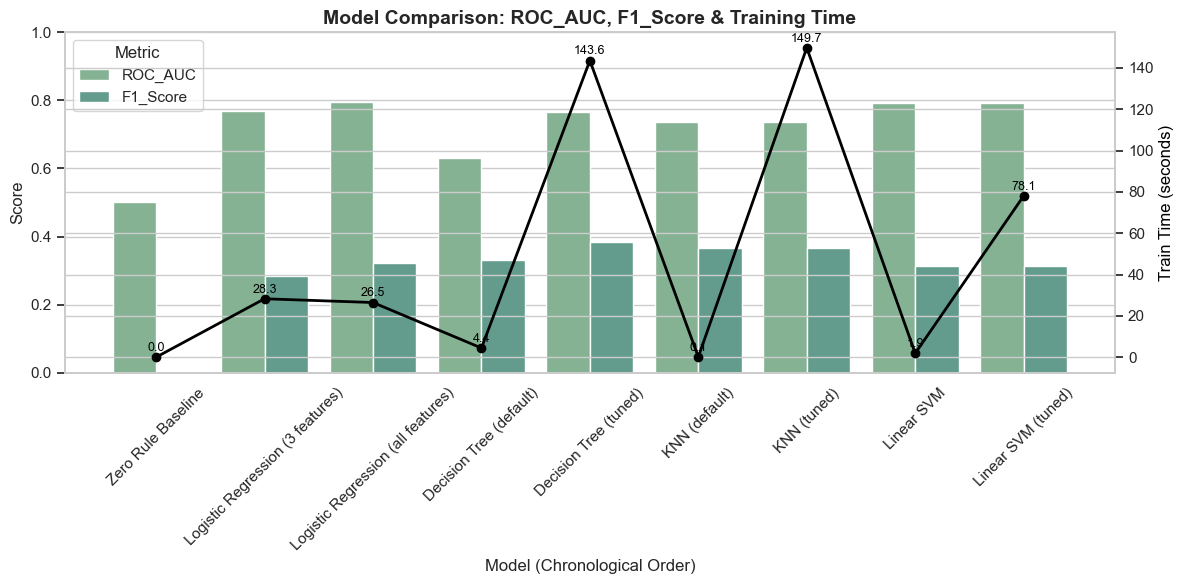

In [22]:
# --- Prepare data for barplot ---
plot_df = results_df.melt(
    id_vars='Model',
    value_vars=['ROC_AUC', 'F1_Score'],
    var_name='Metric',
    value_name='Score'
)

# --- Create the plot ---
sns.set_theme(style="whitegrid", palette="crest")
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for performance metrics
sns.barplot(data=plot_df, x='Model', y='Score', hue='Metric', ax=ax1)
ax1.set_ylim(0, 1)
ax1.set_ylabel('Score')
ax1.set_xlabel('Model (Chronological Order)')
ax1.set_title('Model Comparison: ROC_AUC, F1_Score & Training Time', fontsize=14, weight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metric', loc='upper left')

# --- Secondary y-axis for training time ---
ax2 = ax1.twinx()
ax2.plot(results_df['Model'], results_df['Train Time'], color='black', marker='o', linewidth=2, label='Train Time (s)')
ax2.set_ylabel('Train Time (seconds)', color='black')

# Add numeric labels on each dot
for x, y in zip(results_df['Model'], results_df['Train Time']):
    ax2.text(x, y + max(results_df['Train Time'])*0.02, f'{y:.1f}', color='black', ha='center', fontsize=9)

# Final layout
plt.tight_layout()
plt.show()


**Observations 12** 

- The linear models - Logistic Regression and Linear SVM - seem to perform quite well - suggesting the features in our dataset seem to scale well linearly (i.e. each feature added to the consideration adds up additively to the decision) 
- KNN and Decision Tree on the other hand are more sensitive to dimensionality 

##### _Step 13: Feature Importance_ 

In [31]:
# 1) Get feature names from the SAME fitted preprocessor used for lrall
feature_names = preprocess.get_feature_names_out()

# 2) Clean prefixes like "num__" / "cat__"
clean_feature_names = [n.split('__', 1)[1] if '__' in n else n for n in feature_names]

# 3) Get coefficients (binary LR → shape (1, n_features))
coef = lrall.coef_.ravel()

# 4) Sanity check: lengths must match
assert len(clean_feature_names) == len(coef), (
    f"Name/coef mismatch: {len(clean_feature_names)} names vs {len(coef)} coefs"
)

# 5) Build importance DataFrame (use a 1-D list/Series for the Feature column)
importance_df = pd.DataFrame({
    'Feature': clean_feature_names,
    'Coefficient': coef
})
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)

print(importance_df.head(10))


             Feature  Coefficient  Abs_Coefficient
0       emp.var.rate    -1.412378         1.412378
1          month_mar     0.957471         0.957471
2          month_may    -0.783704         0.783704
3     cons.price.idx     0.559953         0.559953
4          month_jun    -0.519670         0.519670
5   poutcome_failure    -0.516956         0.516956
6          month_nov    -0.505607         0.505607
7    default_unknown    -0.461381         0.461381
8          euribor3m     0.394300         0.394300
9  contacts_all_time    -0.312303         0.312303


In [32]:
# Create a DataFrame to register the top features for each model 
columns = ['Model', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']
summary_df = pd.DataFrame(columns=columns)

# Append values for Logistic Regression 
summary_df.loc[len(summary_df)] = ['Logistic Regression (all features)', 'emp.var.rate', 'month_mar', 'month_may', 'cons.price.idx', 'month_jun'] 
summary_df


,Model,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5
0,Logistic Regression (all features),emp.var.rate,month_mar,month_may,cons.price.idx,month_jun


In [33]:
# Check the top features for the tuned Decision Tree 
importances = dt_tuned.best_estimator_.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': clean_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

              Feature  Importance
5         nr.employed    0.450102
9   contact_intensity    0.107177
4           euribor3m    0.101894
0                 age    0.089475
3       cons.conf.idx    0.047975
8   contacts_all_time    0.020202
49          month_oct    0.017716
51   poutcome_failure    0.012948
10         job_admin.    0.010233
2      cons.price.idx    0.008852


In [34]:
# Append values to summary df
summary_df.loc[len(summary_df)] = ['Decision Tree (tuned)', 'nr.employed', 'contact_intensity', 'euribor3m', 'age', 'cons.conf.idx']
summary_df 

,Model,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5
0,Logistic Regression (all features),emp.var.rate,month_mar,month_may,cons.price.idx,month_jun
1,Decision Tree (tuned),nr.employed,contact_intensity,euribor3m,age,cons.conf.idx


In [35]:
# Check top features for Linear SVM
coefs = svm.best_estimator_.coef_.ravel()   

# 3. Pair with feature names
importance_df = pd.DataFrame({
    'Feature': clean_feature_names,
    'Coefficient': coefs,
    'Abs_Coefficient': np.abs(coefs)
}).sort_values(by='Abs_Coefficient', ascending=False)

# 4. View top 10 important features
print(importance_df.head(10))

              Feature  Coefficient  Abs_Coefficient
1        emp.var.rate    -0.410004         0.410004
46          month_mar     0.358790         0.358790
4           euribor3m     0.221548         0.221548
47          month_may    -0.206903         0.206903
2      cons.price.idx     0.168732         0.168732
51   poutcome_failure    -0.166334         0.166334
45          month_jun    -0.156308         0.156308
8   contacts_all_time    -0.148489         0.148489
9   contact_intensity     0.136316         0.136316
5         nr.employed    -0.133467         0.133467


In [36]:
# Append values to summary df
summary_df.loc[len(summary_df)] = ['Linear SVM (tuned)', 'emp.var.rate', 'month_mar', 'euribor3m', 'month_may', 'cons.price.idx']
summary_df 

,Model,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5
0,Logistic Regression (all features),emp.var.rate,month_mar,month_may,cons.price.idx,month_jun
1,Decision Tree (tuned),nr.employed,contact_intensity,euribor3m,age,cons.conf.idx
2,Linear SVM (tuned),emp.var.rate,month_mar,euribor3m,month_may,cons.price.idx


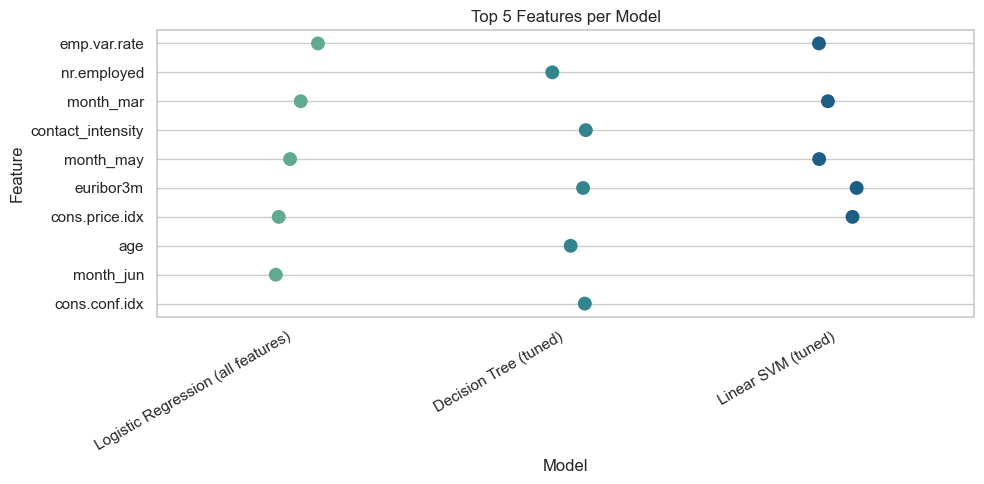

In [38]:
melted = summary_df.melt(id_vars='Model', value_name='Feature')

plt.figure(figsize=(10,5))
sns.stripplot(data=melted, x='Model', y='Feature', hue='Model', dodge=False, s=10, palette='crest')
plt.title('Top 5 Features per Model')
plt.xticks(rotation=30, ha='right')
plt.legend([],[], frameon=False)  # hide duplicate legend
plt.tight_layout()
plt.show()

**Observations 13**

- the two linear models value relatively similar features for importance 
- wider economic factors tend to have a greater impact on whether people would subscribe 
- in general, when times are good, people subscribe less i.e. they prefer to spend 
- month of march is particular good for subscription, whereas summer times ppl save less (maybe out on holiday)
- if the last campaign was a failed one, it is unlikely the user would subscribe this time round 
- users also tend to wane off if they are contacted more times